# Multivariate Gaussian Random Walk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pymc3 as pm
import theano


%matplotlib inline

Simulate the data:

In [2]:
np.random.seed(23)

n_sections = 3
length_section = 50
MU = np.random.randint(-5, 5, n_sections)
SD = 0.5

data = np.random.normal(loc=MU, scale=SD, size=(length_section, n_sections)).flatten(order='F')

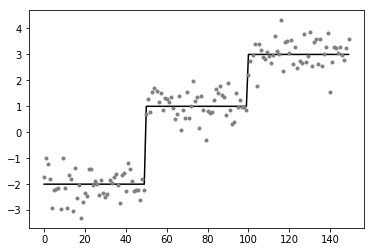

In [3]:
plt.plot(np.repeat(MU, length_section), ls='-', color='black')
plt.plot(data, '.', color='gray');

In [4]:
with pm.Model() as model:
    sigma_mu = pm.HalfNormal('sigma_mu', 1)
    mu = pm.GaussianRandomWalk('mu', 
                               init=pm.Normal.dist(mu=0, sd=25), 
                               sigma=sigma_mu,
                               shape=data.shape[0])
    sigma = pm.HalfNormal('sigma', 5)
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data)

model.check_test_point()

sigma_mu_log__     -0.77
mu               -107.42
sigma_log__        -0.77
likelihood       -369.66
Name: Log-probability of test_point, dtype: float64

In [5]:
chains = 2
with model:
    trace = pm.sample(
                      draws=1000, 
                      chains=chains, 
                      cores=1, 
                      tune=1000, 
                      random_seed=[23 + i for i in np.arange(chains)], 
                      nuts_kwargs={'target_accept':0.90}
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu, sigma_mu]
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 172.80it/s]
The number of effective samples is smaller than 25% for some parameters.


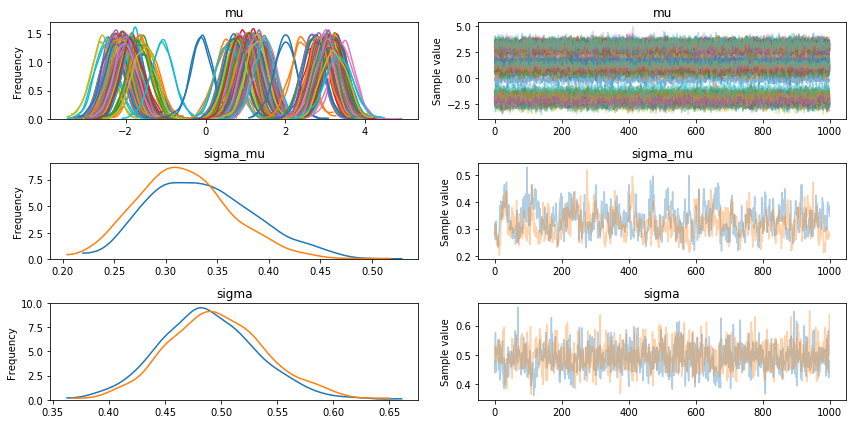

In [6]:
pm.traceplot(trace);

In [7]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2098.59it/s]


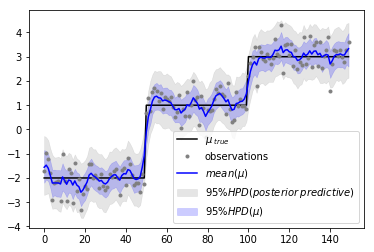

In [8]:
plt.plot(np.repeat(MU, length_section), ls='-', color='black', label='$\mu_{\;true}$')
plt.plot(data, '.', color='gray', label='observations');
plt.plot(trace['mu'].mean(axis=0), '-', color='blue', label='$mean(\mu)$');

plt.fill_between(np.arange(pm.hpd(ppc['likelihood']).shape[0]), 
                 pm.hpd(ppc['likelihood'])[:, 0], 
                 pm.hpd(ppc['likelihood'])[:, 1], 
                 color='gray', lw=0.5, alpha=0.2, 
                 label='$95\% HPD (posterior\;predictive)$');

plt.fill_between(np.arange(pm.hpd(trace['mu']).shape[0]), 
                 pm.hpd(trace['mu'])[:, 0], 
                 pm.hpd(trace['mu'])[:, 1], 
                 color='blue', lw=0.5, alpha=0.2,
                 label='$95\% HPD (\mu)$');
plt.legend();